 # Data Science Unit 2 Sprint Challenge 4 — Model Validation

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

## Predicting Blood Donations

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict the last column, whether the donor made a donation in March 2007, using information about each donor's history. We'll measure success using recall score as the model evaluation metric.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

#### Run this cell to load the data:

In [532]:
from sklearn import base, metrics, pipeline, ensemble, model_selection, linear_model, preprocessing, feature_selection
import pandas as pd
import numpy as np
import warnings

In [263]:
def warn(*args, **kwargs): 
    pass

warnings.warn = warn

In [325]:
warnings.simplefilter("ignore")
warnings.warn("runtime", RuntimeWarning)

In [1]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

## Part 1.1 — Begin with baselines

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You don't need to split the data into train and test sets yet. You can answer this question either with a scikit-learn function or with a pandas function.)

What **recall score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of recall.)

In [23]:
pred = np.full(df.made_donation_in_march_2007.size, df.made_donation_in_march_2007.max())
true = df.made_donation_in_march_2007

In [24]:
# NOTE: per this documentation (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), 
# sklearn's confusion matrix differs in stucture from the one on wikipedia, obviously, this only matters for direct comparison
# but analytically the result will be the same
metrics.confusion_matrix(true, pred)

array([[  0, 570],
       [  0, 178]])

In [29]:
# sklearn
print("Precision:", metrics.accuracy_score(true, pred))
print("Recall:", metrics.recall_score(true, pred))

Precision: 0.237967914439
Recall: 1.0


In [26]:
# implementation
tp = pred[(true == 1) & (pred == 1)].size
fp = pred[(true == 0) & (pred == 1)].size
fn = pred[(true == 1) & (pred == 0)].size
tn = pred[(true == 0) & (pred == 0)].size

In [32]:
np.array([[tp, fp], 
          [fn, tn]])

array([[178, 570],
       [  0,   0]])

In [35]:
print("Precision:", tp/(tp+fp))
print("Recall:",  tp/(tp+fn))

Precision: 0.23796791443850268
Recall: 1.0


## Part 1.2 — Split data

In this Sprint Challenge, you will use "Cross-Validation with Independent Test Set" for your model evaluation protocol.

First, **split the data into `X_train, X_test, y_train, y_test`**, with random shuffle. (You can include 75% of the data in the train set, and hold out 25% for the test set.)


In [39]:
X = df.drop(columns='made_donation_in_march_2007')
y = df.made_donation_in_march_2007

In [42]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.75, test_size=.25)

## Part 2.1 — Make a pipeline

Make a **pipeline** which includes:
- Preprocessing with any scikit-learn [**Scaler**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
- Feature selection with **[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html))**
- Classification with [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [69]:
class ContinuousScaler(base.TransformerMixin):
    def __init__(self):
        self.scaler = preprocessing.StandardScaler()
        
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        
        self.columns = X.select_dtypes(include=np.float).columns.values
        self.locs = np.vectorize(X.columns.get_loc)(self.columns)
        
        self.scaler.fit(X[self.columns]) 
        
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        
        return np.c_[
            X[np.delete(X.columns.values, self.locs)],
            self.scaler.transform(X[self.columns])
        ]

In [46]:
class Logger(base.TransformerMixin):
    def __init__(self, message=None):
        self.message = message
    
    def fit(self, X, y=None):
        return self 
        
    def transform(self, X):
        if self.message is not None:
            print(self.message)
        return X

In [103]:
class LoggerWrapper(base.TransformerMixin):
    def __init__(self, model, fit_message=None, transform_message=None, attr_handler=None):
        self.model = model
        self.fit_message = fit_message
        self.transform_message = transform_message
        self.attr_handler = attr_handler
    
    def fit(self, X, y=None):
        if self.fit_message is not None:
            print(self.fit_message)
            
        self.model.fit(X, y)
        
        return self 
        
    def transform(self, X):
        if self.transform_message is not None:
            print(self.transform_message)
        
        return self.model.transform(X)
    
    def __getattr__(self, attr):
        if self.attr_handler is not None:
            self.attr_handler(attr)
        
        return getattr(self.model, attr)


In [127]:
model = LoggerWrapper(
    linear_model.LogisticRegression(class_weight='balanced'), 
    fit_message='fitting!',
    transform_message='transformed!',
    attr_handler=lambda attr: print("Calling the {} attribute of our model!".format(attr))
)
_ = model.fit(X_train, y_train)
_ = model.predict_proba(X_train)

fitting!
Calling the predict_proba attribute of our model!


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [228]:
ScalingPruningLogisticRegression = pipeline.Pipeline([
    ('kbest', feature_selection.SelectKBest(feature_selection.f_classif, k=1)),
    ('logging_kbest', Logger(message='completed feature selection')),
    ('rscale', preprocessing.PowerTransformer()),
    ('logging_rscale', Logger(message='completed scaling')),
    ('kbest_scaled', feature_selection.SelectKBest(feature_selection.f_classif, k=1)),
    ('logging_kbest_scaled', Logger(message='completed scaled feature selection')),
    ('logreg', linear_model.LogisticRegression(solver='lbfgs')),
])

In [229]:
model = ScalingPruningLogisticRegression.fit(X_train, y_train)

completed feature selection
completed scaling
completed scaled feature selection


In [230]:
metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, [1]])

completed feature selection
completed scaling
completed scaled feature selection


0.64830635491606714

In [284]:
model.named_steps['logreg'].coef_

array([[-0.83870163]])

## Part 2.2 — Do Grid Search Cross-Validation

Do [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with your pipeline. Use **5 folds** and **recall score**.

Include these **parameters for your grid:**

#### `SelectKBest`
- `k : 1, 2, 3, 4`

#### `LogisticRegression`
- `class_weight : None, 'balanced'`
- `C : .0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0`


**Fit** on the appropriate data.

In [366]:
ScalingPruningLogisticRegression = pipeline.Pipeline([
    ('rscale', preprocessing.MinMaxScaler()),
    ('kbest', feature_selection.SelectKBest(feature_selection.f_classif)),
    ('logreg', linear_model.LogisticRegression(solver='lbfgs')),
])

In [367]:
params = dict(
    kbest__k=[1, 2, 3, 4],
    logreg__class_weight=[None, 'balanced'],
    logreg__C=[.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
)

In [368]:
search = model_selection.GridSearchCV(
    ScalingPruningLogisticRegression,
    cv=5,
    param_grid=params,
    scoring=metrics.make_scorer(metrics.recall_score)
)

In [369]:
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('rscale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f140757b400>)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': [1, 2, 3, 4], 'logreg__class_weight': [None, 'balanced'], 'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(recall_score), verbose=0)

In [370]:
predictions = search.best_estimator_.predict(X_test)
metrics.recall_score(y_test, predictions)

0.86956521739130432

## Part 3 — Show best score and parameters

Display your **best cross-validation score**, and the **best parameters** (the values of `k, class_weight, C`) from the grid search.

(You're not evaluated here on how good your score is, or which parameters you find. You're only evaluated on being able to display the information. There are several ways you can get the information, and any way is acceptable.)

In [268]:
search.best_score_

0.7847250788427258

In [269]:
search.best_params_

{'kbest__k': 1, 'logreg__C': 0.0001, 'logreg__class_weight': 'balanced'}

## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Predicted</th>
  </tr>
  <tr>
    <th>Negative</th>
    <th>Positive</th>
  </tr>
  <tr>
    <th rowspan="2">Actual</th>
    <th>Negative</th>
    <td>85</td>
    <td>58</td>
  </tr>
  <tr>
    <th>Positive</th>
    <td>8</td>
    <td>36</td>
  </tr>
</table>

In [270]:
tp = 46
fp = 58
tn = 85
fn = 8

Calculate accuracy

In [275]:
(tp+tn)/(tp+tp+tn+fn)

0.7081081081081081

Calculate precision

In [277]:
tp/(tp+fp)

0.4423076923076923

Calculate recall

In [276]:
tp/(tp+fn)

0.8518518518518519

## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

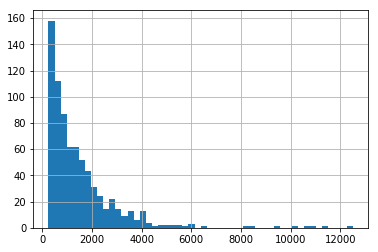

In [290]:
df.total_volume_donated.hist(bins=50)

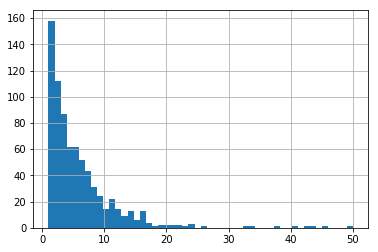

In [291]:
df.number_of_donations.hist(bins=50)

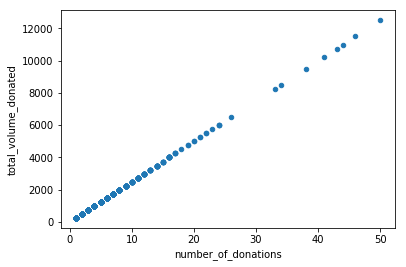

In [292]:
df.plot.scatter(x='number_of_donations', y='total_volume_donated')

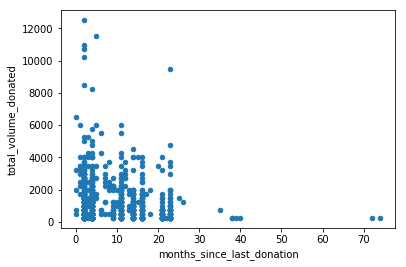

In [294]:
df.plot.scatter(x='months_since_last_donation', y='total_volume_donated')

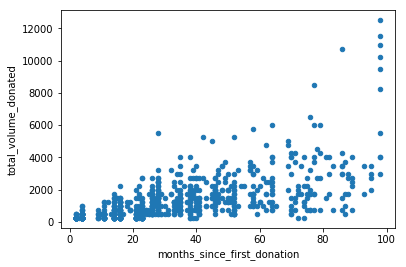

In [295]:
df.plot.scatter(x='months_since_first_donation', y='total_volume_donated')

In [298]:
df['blood_given_per_donation'] = df.number_of_donations/df.total_volume_donated
df['months_where_donation_was_given'] = df.months_since_first_donation - df.months_since_last_donation
df['total_volume_averaged_per_month'] = df.total_volume_donated/df.months_where_donation_was_given
df['above_average_blood_donations'] = df.number_of_donations > df.number_of_donations.mean()
df['above_average_blood_donation'] = df.total_volume_donated > df.total_volume_donated.mean()

In [310]:
df.total_volume_averaged_per_month = df.total_volume_averaged_per_month.replace({np.inf: 0})

In [311]:
df.isna().sum()

months_since_last_donation         0
number_of_donations                0
total_volume_donated               0
months_since_first_donation        0
made_donation_in_march_2007        0
blood_given_per_donation           0
months_where_donation_was_given    0
total_volume_averaged_per_month    0
above_average_blood_donations      0
above_average_blood_donation       0
dtype: int64

In [312]:
(df == np.inf).sum()

months_since_last_donation         0
number_of_donations                0
total_volume_donated               0
months_since_first_donation        0
made_donation_in_march_2007        0
blood_given_per_donation           0
months_where_donation_was_given    0
total_volume_averaged_per_month    0
above_average_blood_donations      0
above_average_blood_donation       0
dtype: int64

In [313]:
X = df.drop(columns='made_donation_in_march_2007')
y = df.made_donation_in_march_2007

In [314]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.75, test_size=.25)

In [389]:
ScalingPruningLogisticRegression = pipeline.Pipeline([
    ('standardscale', preprocessing.StandardScaler()),
    ('kbest', feature_selection.SelectKBest(feature_selection.f_classif)),
    ('logreg', linear_model.LogisticRegression(solver='lbfgs')),
])

In [390]:
params = dict(
    kbest__k=np.arange(X.columns.values.size)+1,
    logreg__class_weight=[None, 'balanced'],
    logreg__C=[.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
)

In [391]:
search = model_selection.GridSearchCV(
    ScalingPruningLogisticRegression,
    cv=5,
    param_grid=params,
    scoring=metrics.make_scorer(metrics.recall_score)
)

In [392]:
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f140757b400>)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'logreg__class_weight': [None, 'balanced'], 'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(recall_score), verbose=0)

In [393]:
probabilities = search.predict_proba(X_test)[:, 1]

In [394]:
metrics.roc_auc_score(y_test, probabilities)

0.78970089423373424

In [395]:
search.best_score_

0.78102035945173198

In [396]:
search.best_params_

{'kbest__k': 2, 'logreg__C': 1.0, 'logreg__class_weight': 'balanced'}

In [397]:
predictions = search.best_estimator_.predict(X_test)
metrics.recall_score(y_test, predictions)

0.86956521739130432

### Part 2
Add transformations in your pipeline and parameters in your grid, to try improving your cross-validation score.

#### Overfitting

In [484]:
ScalingPruningLogisticRegression = pipeline.Pipeline([
    ('standardscale', preprocessing.StandardScaler()),
    ('power', preprocessing.PowerTransformer()),
    ('kbest', feature_selection.SelectKBest(feature_selection.f_classif)),
    ('logreg', linear_model.LogisticRegression(solver='lbfgs')),
])

In [485]:
params = dict(
    kbest__k=np.arange(X.columns.values.size)+1,
    logreg__class_weight=[None, {0: 0.5, 1: 1}, 'balanced'],
    logreg__C=[.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]#,
)

In [486]:
search = model_selection.GridSearchCV(
    ScalingPruningLogisticRegression,
    cv=10,
    param_grid=params,
    scoring=metrics.make_scorer(metrics.recall_score)
)

In [489]:
search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f140757b400>)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'logreg__class_weight': [None, {0: 0.5, 1: 1}, 'balanced'], 'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(recall_score), verbose=0)

In [490]:
probabilities = search.predict_proba(X_test)[:, 1]

In [491]:
metrics.roc_auc_score(y_test, probabilities)

0.7895467160037003

In [492]:
search.best_score_

0.77174785998315421

In [493]:
search.best_params_

{'kbest__k': 2, 'logreg__C': 0.1, 'logreg__class_weight': 'balanced'}

In [494]:
predictions = search.best_estimator_.predict(X_test)
metrics.recall_score(y_test, predictions)

0.86956521739130432

#### Tuning

In [655]:
ScalingPruningLogisticRegression = pipeline.Pipeline(
    [
        ('standardscale', preprocessing.StandardScaler()),
        ('kbest', feature_selection.SelectKBest(feature_selection.f_classif, k='all')),
        ('grad', ensemble.GradientBoostingClassifier())
    ],
    memory=None
)

In [656]:
params = dict(
    kbest__k=np.arange(X_train.columns.values.size)+1,
    grad__loss=['deviance', 'exponential'],
    grad__learning_rate=[0.01, 0.1, 1, 10, 100, 1000, 10000]
)

In [657]:
search = model_selection.GridSearchCV(
    ScalingPruningLogisticRegression,
    cv=5,
    param_grid=params,
    scoring=metrics.make_scorer(metrics.recall_score)
)

In [658]:
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k='all', score_func=<function f_classif at 0x7f140757b400>)), ('grad', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'grad__loss': ['deviance', 'exponential'], 'grad__learning_rate': [0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(recall_score), verbose=0)

In [659]:
probabilities = search.predict_proba(X_test)[:, 1]

In [660]:
metrics.roc_auc_score(y_test, probabilities)

0.4815757015109467

In [661]:
search.best_score_

0.97703277115041831

In [662]:
search.best_params_

{'grad__learning_rate': 100, 'grad__loss': 'deviance', 'kbest__k': 1}

In [663]:
predictions = search.best_estimator_.predict(X_train)
metrics.precision_score(y_train, predictions)

0.23388581952117865

In [664]:
predictions = search.best_estimator_.predict(X_test)
metrics.precision_score(y_test, predictions)

0.2388888888888889

In [665]:
predictions = search.best_estimator_.predict(X_train)
metrics.recall_score(y_train, predictions)

0.96212121212121215

In [666]:
predictions = search.best_estimator_.predict(X_test)
metrics.recall_score(y_test, predictions)

0.93478260869565222

### Part 3
Show names of selected features. Then do a final evaluation on the test set — what is the test score?

In [679]:
# ?, re-running the model would be too time-consuming at the moment, will re-run later
X_train.columns.values[search.estimator.named_steps['kbest'].get_support()]

NotFittedError: This SelectKBest instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

### Part 4
Calculate F1 score and False Positive Rate.

In [627]:
tp = predictions[(y_test == 1) & (predictions == 1)].size
fp = predictions[(y_test == 0) & (predictions == 1)].size
tn = predictions[(y_test == 0) & (predictions == 0)].size
fn = predictions[(y_test == 1) & (predictions == 0)].size

In [634]:
f1 = (2*tp)/(2*tp+fp+fn)
fpr = fp/(fp+tn)

In [641]:
np.testing.assert_almost_equal(metrics.f1_score(y_test, predictions), f1)

In [635]:
print("F1 Score:", f1)
print("False Positive Rate:", fpr)

F1 Score: 0.3805309734513274
False Positive Rate: 0.9716312056737588
